Importar todas las librerías necesarias

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import re
import nltk
import pandas as pd
from pathlib import Path  
import os
import matplotlib.pyplot as plt
import warnings

# Descargar stopwords si no están disponibles
try:
    from nltk.corpus import stopwords
    STOPWORDS = set(stopwords.words('english'))
except:
    nltk.download('stopwords', quiet=True)
    from nltk.corpus import stopwords
    STOPWORDS = set(stopwords.words('english'))

# Configuración de estilo
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10



Definir rutas de los archivos y cargar todas las noticias en un mismo DataFrame

In [2]:
# Define directories
PROCESSED_DIR = Path("..") / "data" / "news" / "processed"
SUMMARIES_DIR = Path("..") / "data" / "news" / "summarized"

# Load all processed news files
processed_files = list(PROCESSED_DIR.glob("*.parquet"))
df_processed = pd.concat(
    [pd.read_parquet(file) for file in processed_files],
    ignore_index=True
)

# Load all summarized news files
summarized_files = list(SUMMARIES_DIR.glob("*.parquet"))
df_summarized = pd.concat(
    [pd.read_parquet(file) for file in summarized_files],
    ignore_index=True
)

# Check the first rows of each dataframe
print("DF Processed:")
print(df_processed.head())
print("\n==============================\n")
print("\nDF Summarized:")
print(df_summarized.head())


DF Processed:
        id    author                          created  \
0  5117631  Benzinga  Mon, 05 Jan 2015 07:03:23 -0400   
1  5117820  Benzinga  Mon, 05 Jan 2015 08:00:01 -0400   
2  5118518  Benzinga  Mon, 05 Jan 2015 10:02:27 -0400   
3  5126889  Benzinga  Wed, 07 Jan 2015 10:08:50 -0400   
4  5127155  Benzinga  Wed, 07 Jan 2015 11:05:39 -0400   

                                               title teaser  \
0  Amazon Announces Sellers Sold 2B+ Items Worldw...   None   
1     US Stock Futures Slip Ahead Of Auto Sales Data   None   
2  More Than 2 Billion Items Sold By Amazon Selle...   None   
3  ChannelAdvisor Reports Holiday '14 Total Same-...   None   
4  ChannelAdvisor Reports December Online Same-St...   None   

                                          clean_body  
0  Amazon     \n      (NASDAQ: AMZN ) today annou...  
1  Pre-open movers US stock futures traded lower ...  
2  Amazon.com, Inc. (NASDAQ: AMZN ) announced Mon...  
3  http://www.channeladvisor.com/blog/?pn=sc

In [3]:
df_summarized = pd.read_parquet("../data/news/old/apple_news.parquet")

df_summarized["text"] = df_summarized["title"] + "\n\n" + df_summarized["body_summary"]



# Buscar filas donde la palabra 'salvagedata' aparezca
mask = df_summarized['text'].str.count(r'\bsalvagedata\b', flags=re.IGNORECASE)
print(mask.sum())


FileNotFoundError: [Errno 2] No such file or directory: '../data/news/old/apple_news.parquet'

Análisis de valores nulos en columnas textuales

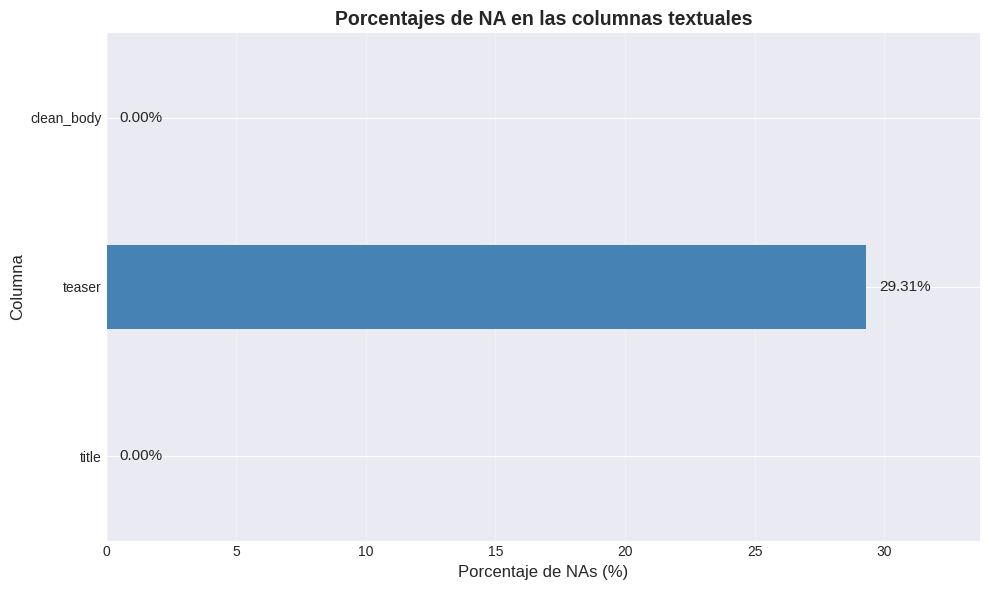

In [4]:
# Count NAs in textual columns
textual_columns = ['title', 'teaser', 'clean_body']
total_rows = len(df_processed)
na_counts = df_processed[textual_columns].isna().sum()
na_percentages = (na_counts / total_rows) * 100

# Create horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 6))
na_percentages.plot(kind='barh', ax=ax, color='steelblue')
ax.set_xlabel('Porcentaje de NAs (%)', fontsize=12)
ax.set_ylabel('Columna', fontsize=12)
ax.set_title('Porcentajes de NA en las columnas textuales', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Set x-axis limit to accommodate labels
max_value = na_percentages.max()
ax.set_xlim(0, max_value * 1.15)

# Add value labels on bars
for i, v in enumerate(na_percentages):
    ax.text(v + 0.5, i, f'{v:.2f}%', va='center', fontsize=11)

plt.tight_layout()
plt.show()


A continuación se realizará un análisis de datos del DataFrame resumido.

In [5]:
df = df_summarized.copy()

df["text"] = df["title"] + "\n\n" + df["body_summary"]

text_col = "text"


print(f"📝 Usando columna de texto: '{text_col}'")
print(f"📊 Número total de textos: {len(df)}")
print(f"📋 Columnas disponibles: {list(df.columns)}")

# Eliminar NaN de la columna de texto
df = df.dropna(subset=[text_col]).copy()
df['text'] = df[text_col].astype(str)

# Detectar si existen columnas de categoría y fecha
has_category = 'category' in df.columns or 'source' in df.columns or 'provider' in df.columns
has_date = 'date' in df.columns or 'publish_time' in df.columns or 'timestamp' in df.columns

category_col = None
date_col = None

if has_category:
    for col in ['category', 'source', 'provider']:
        if col in df.columns:
            category_col = col
            break
    print(f"📂 Columna de categorías detectada: '{category_col}'")

if has_date:
    for col in ['date', 'publish_time', 'timestamp']:
        if col in df.columns:
            date_col = col
            break
    print(f"📅 Columna de fecha detectada: '{date_col}'")
    # Convertir a datetime
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')

print(f"\n✅ Dataframe preparado: {len(df)} registros válidos")

📝 Usando columna de texto: 'text'
📊 Número total de textos: 115405
📋 Columnas disponibles: ['id', 'author', 'created', 'title', 'teaser', 'clean_body', 'body_summary', 'text']

✅ Dataframe preparado: 115404 registros válidos


## Distribución de Palabras Más Frecuentes

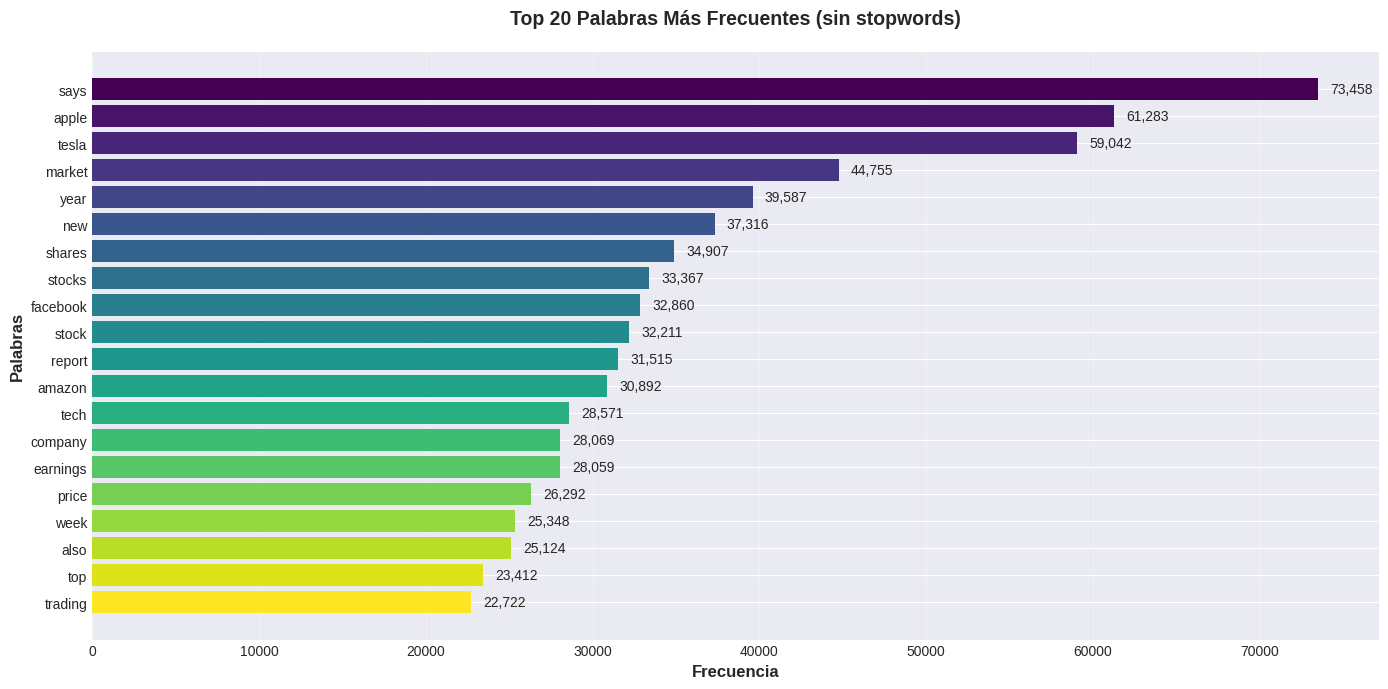

Total de palabras únicas (sin stopwords): 67,208
Total de palabras procesadas (sin stopwords): 5,866,863
Total de palabras con stopwords: 8,978,220
Stopwords eliminadas: 3,111,357 (34.7%)


In [6]:
# Extraer todas las palabras (sin stopwords)
all_words = []
all_words_with_stopwords = []

for text in df['text']:
    words = re.findall(r'\b[a-zA-Z]{2,}\b', str(text).lower())
    all_words_with_stopwords.extend(words)
    # Filtrar stopwords
    words_filtered = [word for word in words if word not in STOPWORDS and len(word) > 2]
    all_words.extend(words_filtered)

# Contar palabras
word_counts = Counter(all_words)
most_common = word_counts.most_common(20)

# Bar plot de las 20 palabras más comunes
fig, ax = plt.subplots(figsize=(14, 7))
words, counts = zip(*most_common)
bars = ax.barh(range(len(words)), counts, color=plt.cm.viridis(np.linspace(0, 1, len(words))))
ax.set_yticks(range(len(words)))
ax.set_yticklabels(words)
ax.invert_yaxis()
ax.set_xlabel('Frecuencia', fontsize=12, fontweight='bold')
ax.set_ylabel('Palabras', fontsize=12, fontweight='bold')
ax.set_title('Top 20 Palabras Más Frecuentes (sin stopwords)', fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3)

# Añadir valores en las barras
for i, (word, count) in enumerate(most_common):
    ax.text(count + max(counts)*0.01, i, f'{count:,}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

print(f"Total de palabras únicas (sin stopwords): {len(word_counts):,}")
print(f"Total de palabras procesadas (sin stopwords): {len(all_words):,}")
print(f"Total de palabras con stopwords: {len(all_words_with_stopwords):,}")
print(f"Stopwords eliminadas: {len(all_words_with_stopwords) - len(all_words):,} ({(len(all_words_with_stopwords) - len(all_words))/len(all_words_with_stopwords)*100:.1f}%)")

## Wordcloud de palabras más frecuentes

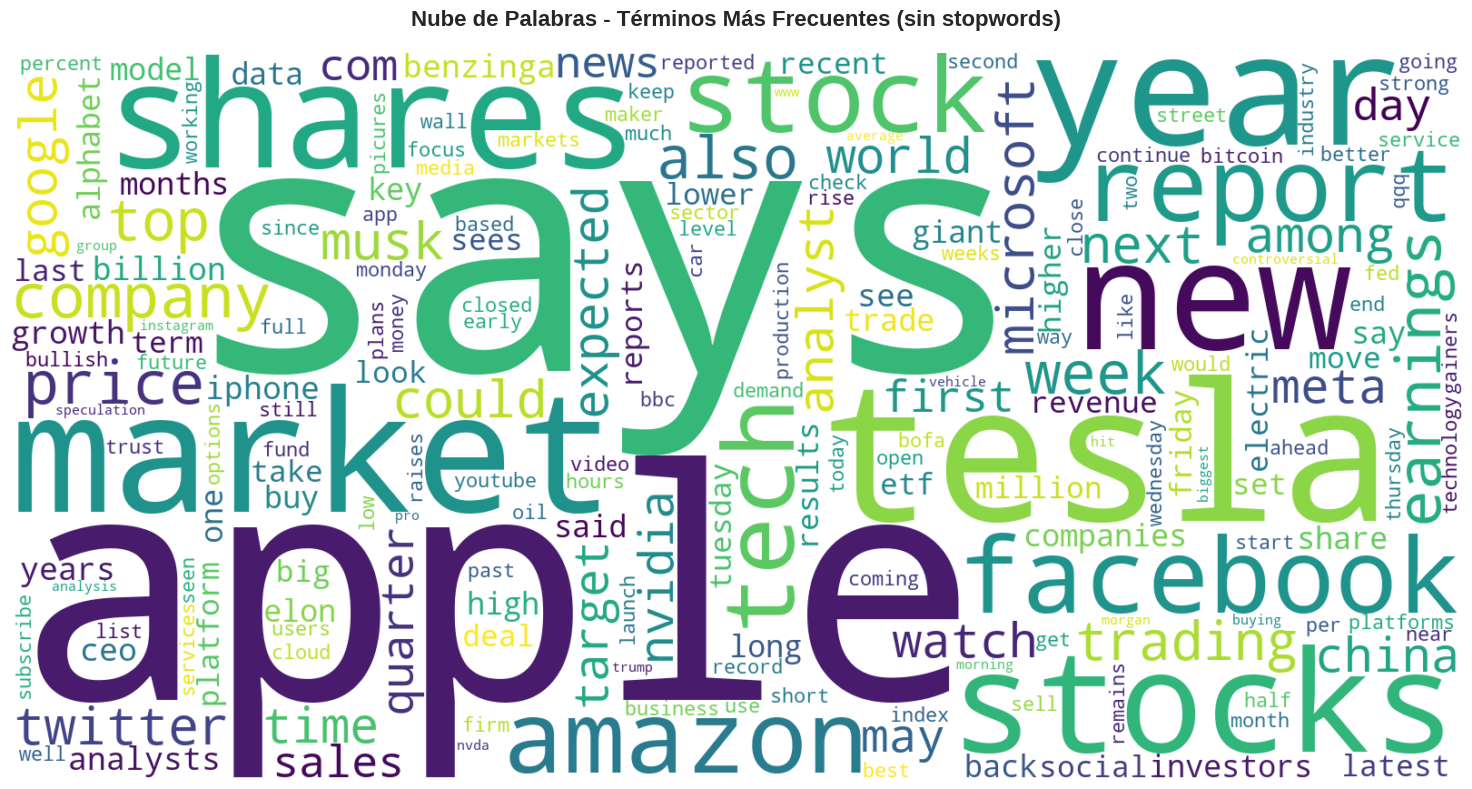

In [7]:
# Word Cloud (sin stopwords)
fig, ax = plt.subplots(figsize=(16, 8))
wordcloud = WordCloud(
    width=1600, 
    height=800, 
    background_color='white',
    colormap='viridis',
    max_words=200,
    relative_scaling=0.5,
    min_font_size=10,
    stopwords=STOPWORDS,  # Asegurar que stopwords están excluidas
    collocations=False  # Evitar repeticiones de pares de palabras
).generate_from_frequencies(word_counts)

ax.imshow(wordcloud, interpolation='bilinear')
ax.axis('off')
ax.set_title('Nube de Palabras - Términos Más Frecuentes (sin stopwords)', 
             fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

## Longitud de Textos (Caracteres y Palabras)

📊 ESTADÍSTICAS DE LONGITUD DE TEXTOS

🔤 Caracteres:
count    115404.000000
mean        495.892135
std         166.547948
min         213.000000
25%         410.000000
50%         446.000000
75%         498.000000
max        2146.000000
Name: char_length, dtype: float64

📝 Palabras:
count    115404.000000
mean         81.257296
std          27.234793
min          19.000000
25%          67.000000
50%          74.000000
75%          82.000000
max         350.000000
Name: word_count, dtype: float64


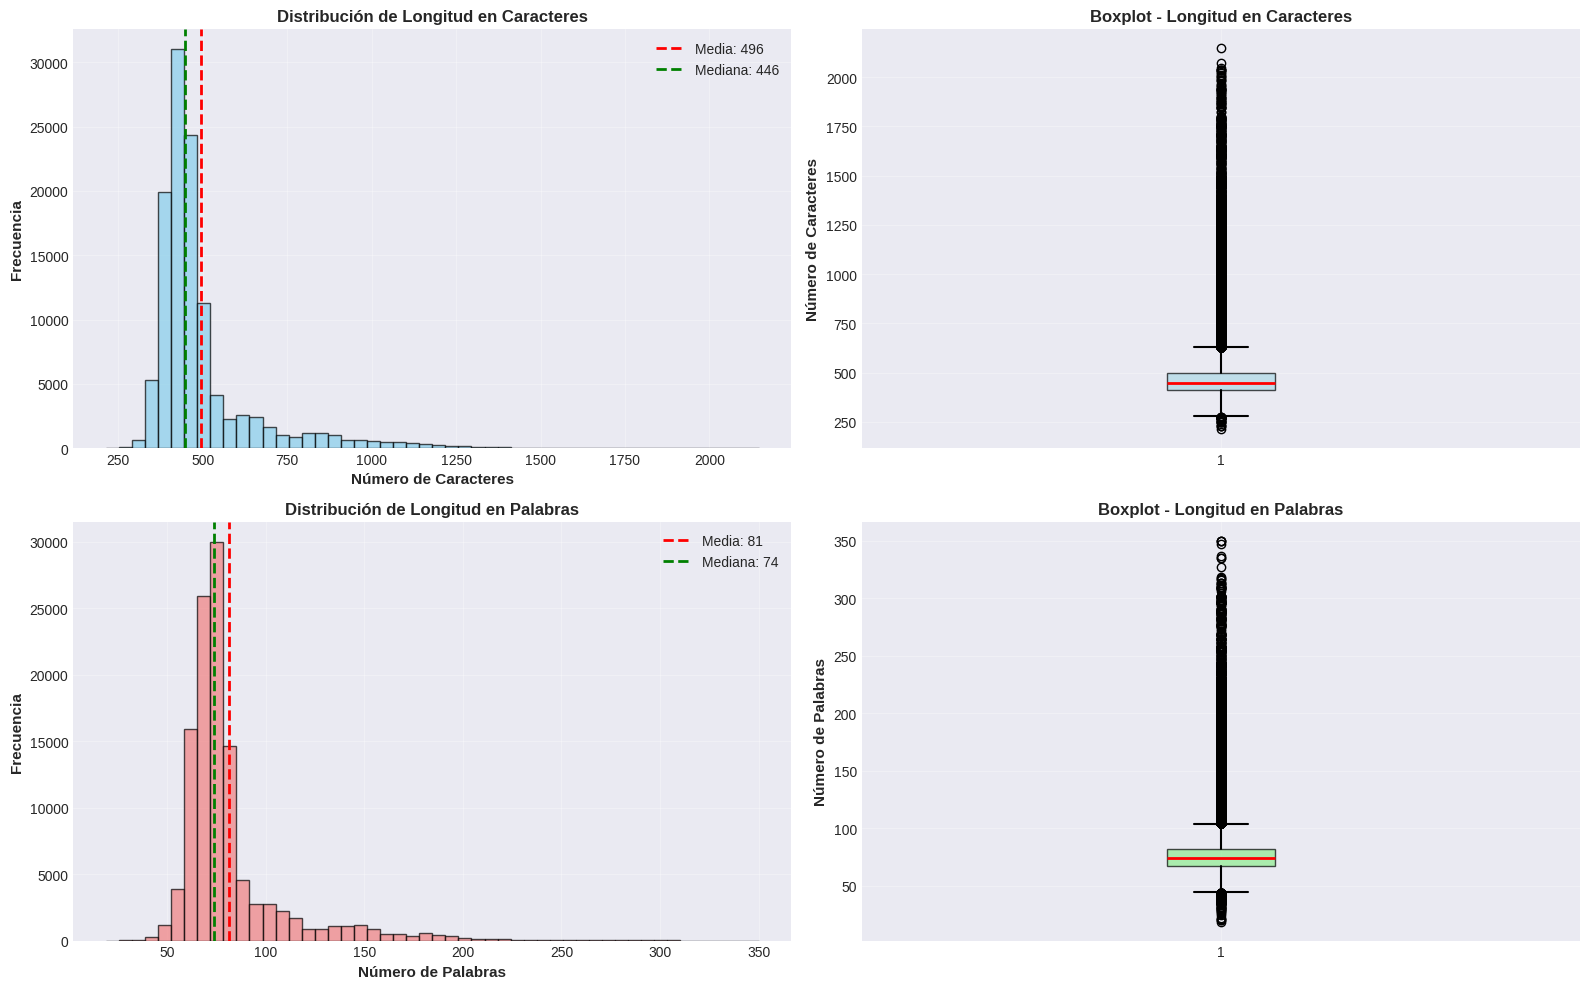

In [8]:
# Calcular longitudes
df['char_length'] = df['text'].str.len()
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

# Estadísticas descriptivas
print("📊 ESTADÍSTICAS DE LONGITUD DE TEXTOS")
print("="*50)
print("\n🔤 Caracteres:")
print(df['char_length'].describe())
print("\n📝 Palabras:")
print(df['word_count'].describe())

# Visualización
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Histograma - Caracteres
axes[0, 0].hist(df['char_length'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(df['char_length'].mean(), color='red', linestyle='--', linewidth=2, label=f'Media: {df["char_length"].mean():.0f}')
axes[0, 0].axvline(df['char_length'].median(), color='green', linestyle='--', linewidth=2, label=f'Mediana: {df["char_length"].median():.0f}')
axes[0, 0].set_xlabel('Número de Caracteres', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Frecuencia', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Distribución de Longitud en Caracteres', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Boxplot - Caracteres
axes[0, 1].boxplot(df['char_length'], vert=True, patch_artist=True,
                    boxprops=dict(facecolor='lightblue', alpha=0.7),
                    medianprops=dict(color='red', linewidth=2),
                    whiskerprops=dict(linewidth=1.5),
                    capprops=dict(linewidth=1.5))
axes[0, 1].set_ylabel('Número de Caracteres', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Boxplot - Longitud en Caracteres', fontsize=12, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# Histograma - Palabras
axes[1, 0].hist(df['word_count'], bins=50, color='lightcoral', edgecolor='black', alpha=0.7)
axes[1, 0].axvline(df['word_count'].mean(), color='red', linestyle='--', linewidth=2, label=f'Media: {df["word_count"].mean():.0f}')
axes[1, 0].axvline(df['word_count'].median(), color='green', linestyle='--', linewidth=2, label=f'Mediana: {df["word_count"].median():.0f}')
axes[1, 0].set_xlabel('Número de Palabras', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Frecuencia', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Distribución de Longitud en Palabras', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Boxplot - Palabras
axes[1, 1].boxplot(df['word_count'], vert=True, patch_artist=True,
                    boxprops=dict(facecolor='lightgreen', alpha=0.7),
                    medianprops=dict(color='red', linewidth=2),
                    whiskerprops=dict(linewidth=1.5),
                    capprops=dict(linewidth=1.5))
axes[1, 1].set_ylabel('Número de Palabras', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Boxplot - Longitud en Palabras', fontsize=12, fontweight='bold')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## N-grams Más Frecuentes (Bi-grams y Tri-grams)

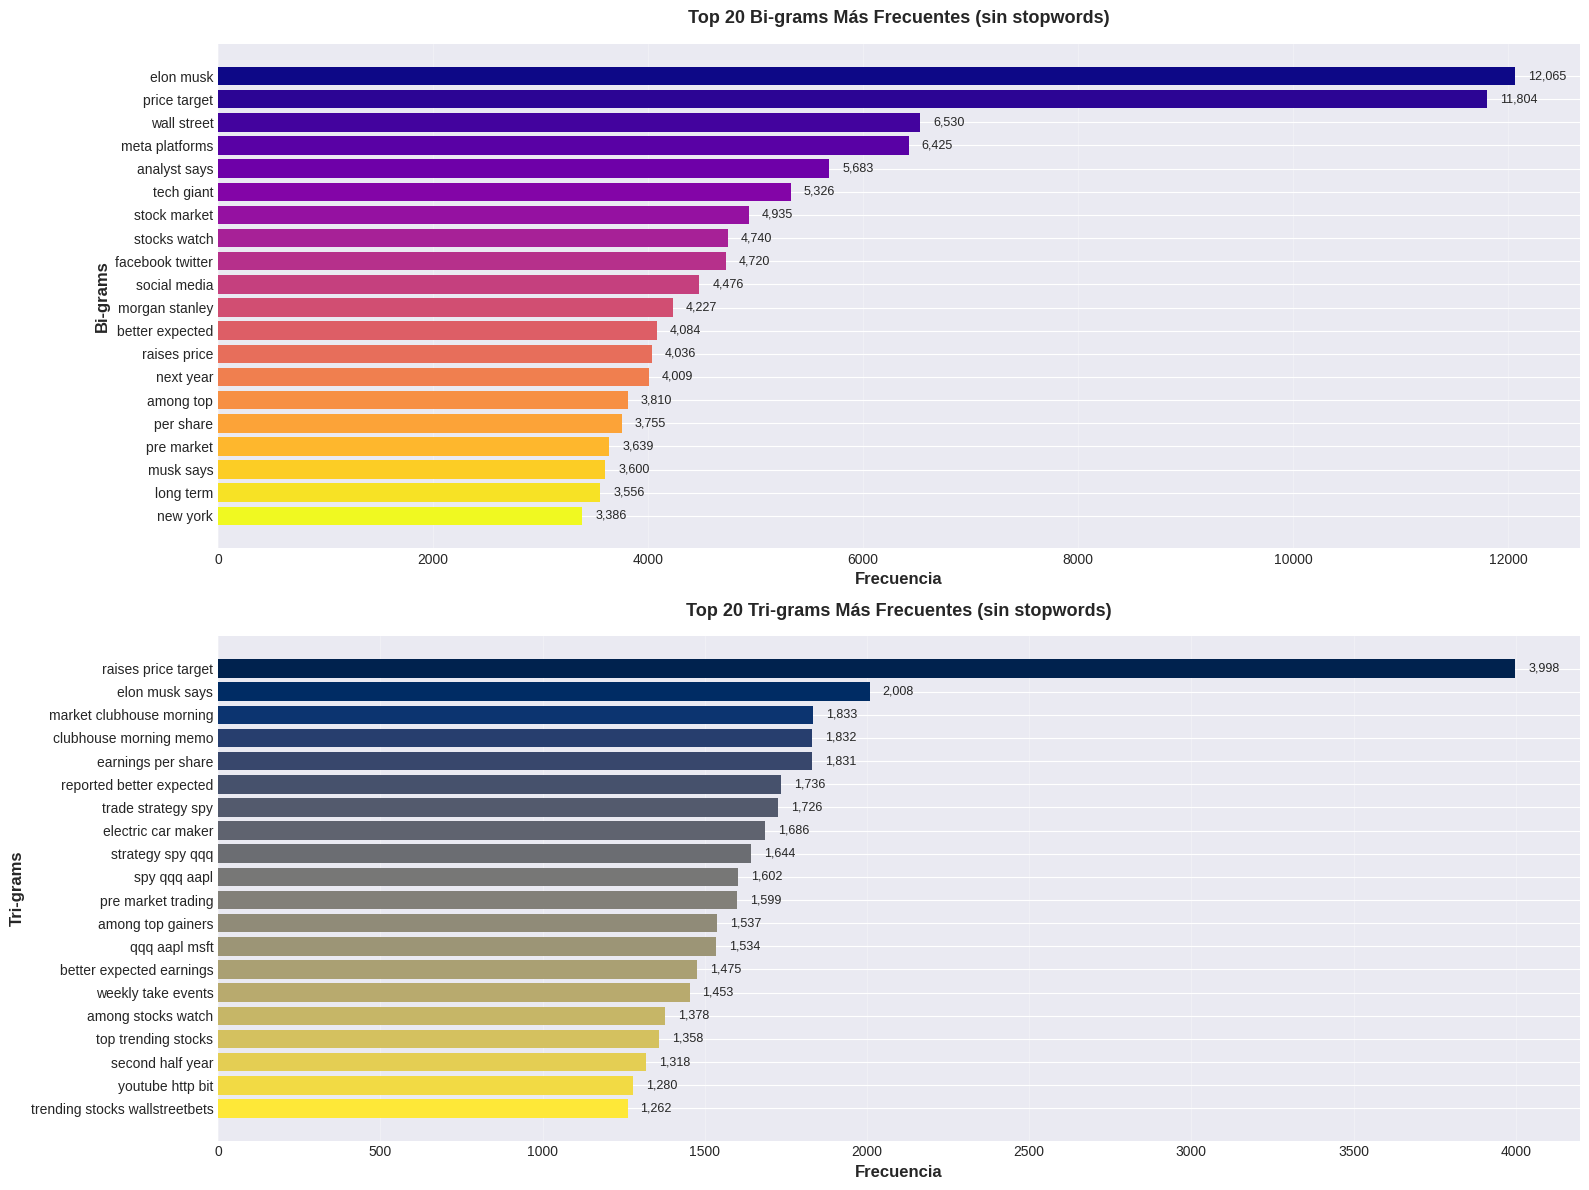

Total de bi-grams únicos (sin stopwords): 1,399,630
Total de tri-grams únicos (sin stopwords): 2,767,331


In [9]:
from collections import defaultdict

def get_ngrams(text, n, remove_stopwords=True):
    """Extraer n-grams de un texto (opcionalmente sin stopwords)"""
    words = re.findall(r'\b[a-zA-Z]{2,}\b', str(text).lower())
    
    if remove_stopwords:
        # Filtrar stopwords y palabras muy cortas
        words = [word for word in words if word not in STOPWORDS and len(word) > 2]
    
    ngrams = zip(*[words[i:] for i in range(n)])
    return [' '.join(ngram) for ngram in ngrams]

# Extraer bi-grams y tri-grams (sin stopwords)
bigrams = []
trigrams = []

for text in df['text']:
    bigrams.extend(get_ngrams(text, 2, remove_stopwords=True))
    trigrams.extend(get_ngrams(text, 3, remove_stopwords=True))

# Contar n-grams
bigram_counts = Counter(bigrams)
trigram_counts = Counter(trigrams)

top_bigrams = bigram_counts.most_common(20)
top_trigrams = trigram_counts.most_common(20)

# Visualización
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# Bi-grams
if top_bigrams:
    bigram_words, bigram_cnts = zip(*top_bigrams)
    axes[0].barh(range(len(bigram_words)), bigram_cnts, 
                 color=plt.cm.plasma(np.linspace(0, 1, len(bigram_words))))
    axes[0].set_yticks(range(len(bigram_words)))
    axes[0].set_yticklabels(bigram_words, fontsize=10)
    axes[0].invert_yaxis()
    axes[0].set_xlabel('Frecuencia', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Bi-grams', fontsize=12, fontweight='bold')
    axes[0].set_title('Top 20 Bi-grams Más Frecuentes (sin stopwords)', fontsize=13, fontweight='bold', pad=15)
    axes[0].grid(axis='x', alpha=0.3)
    
    # Añadir valores
    for i, (word, count) in enumerate(top_bigrams):
        axes[0].text(count + max(bigram_cnts)*0.01, i, f'{count:,}', 
                    va='center', fontsize=9)

# Tri-grams
if top_trigrams:
    trigram_words, trigram_cnts = zip(*top_trigrams)
    axes[1].barh(range(len(trigram_words)), trigram_cnts, 
                 color=plt.cm.cividis(np.linspace(0, 1, len(trigram_words))))
    axes[1].set_yticks(range(len(trigram_words)))
    axes[1].set_yticklabels(trigram_words, fontsize=10)
    axes[1].invert_yaxis()
    axes[1].set_xlabel('Frecuencia', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Tri-grams', fontsize=12, fontweight='bold')
    axes[1].set_title('Top 20 Tri-grams Más Frecuentes (sin stopwords)', fontsize=13, fontweight='bold', pad=15)
    axes[1].grid(axis='x', alpha=0.3)
    
    # Añadir valores
    for i, (word, count) in enumerate(top_trigrams):
        axes[1].text(count + max(trigram_cnts)*0.01, i, f'{count:,}', 
                    va='center', fontsize=9)

plt.tight_layout()
plt.show()

print(f"Total de bi-grams únicos (sin stopwords): {len(bigram_counts):,}")
print(f"Total de tri-grams únicos (sin stopwords): {len(trigram_counts):,}")

## Correlaciones de Palabras

🔍 Creando matriz TF-IDF con 5000 documentos...
✅ Matriz TF-IDF creada: (5000, 100)


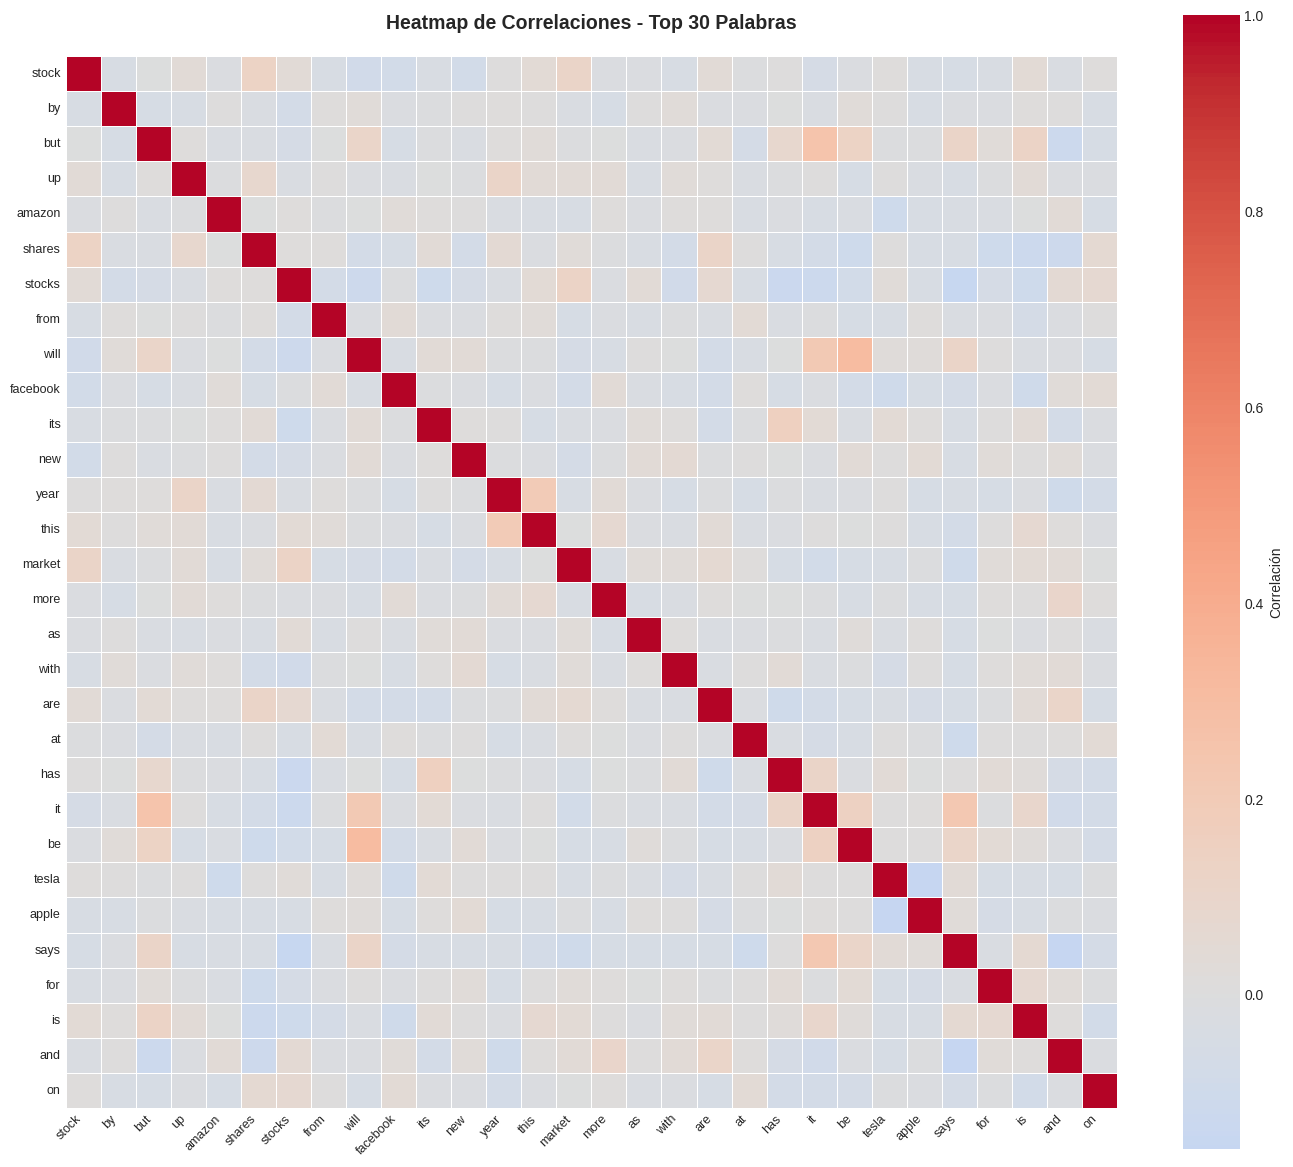

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Crear matriz TF-IDF (usando un subset si el dataset es muy grande)
sample_size = min(5000, len(df))
df_sample = df.sample(n=sample_size, random_state=42)

print(f"🔍 Creando matriz TF-IDF con {sample_size} documentos...")

vectorizer = TfidfVectorizer(
    max_features=100,  # Top 100 palabras
    min_df=2,
    max_df=0.8,
    ngram_range=(1, 1)
)

tfidf_matrix = vectorizer.fit_transform(df_sample['text'])
feature_names = vectorizer.get_feature_names_out()

print(f"✅ Matriz TF-IDF creada: {tfidf_matrix.shape}")

# Matriz de correlación entre palabras
correlation_matrix = np.corrcoef(tfidf_matrix.toarray().T)

# Seleccionar top 30 palabras más frecuentes para el heatmap
top_n = min(30, len(feature_names))
top_indices = np.argsort(np.array(tfidf_matrix.sum(axis=0)).flatten())[-top_n:]
top_features = [feature_names[i] for i in top_indices]
top_corr = correlation_matrix[np.ix_(top_indices, top_indices)]

# Heatmap de correlaciones
fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(top_corr, 
            xticklabels=top_features, 
            yticklabels=top_features,
            cmap='coolwarm', 
            center=0,
            annot=False,
            fmt='.2f',
            square=True,
            linewidths=0.5,
            cbar_kws={'label': 'Correlación'})
ax.set_title(f'Heatmap de Correlaciones - Top {top_n} Palabras', 
             fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.show()